In [ ]:
!pip install catboost
!pip install category_encoders

In [1]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
# 데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt
# 경고 무시 및 난수 생성
import warnings, random
warnings.filterwarnings(action='ignore')
# 머신 러닝 평가 및 전처리 도구
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
# 범주형 데이터 인코딩 및 모델 평가
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
# 클러스터링 및 부스팅 알고리즘
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [2]:
path = '/kaggle/input/dacon-credit/open/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

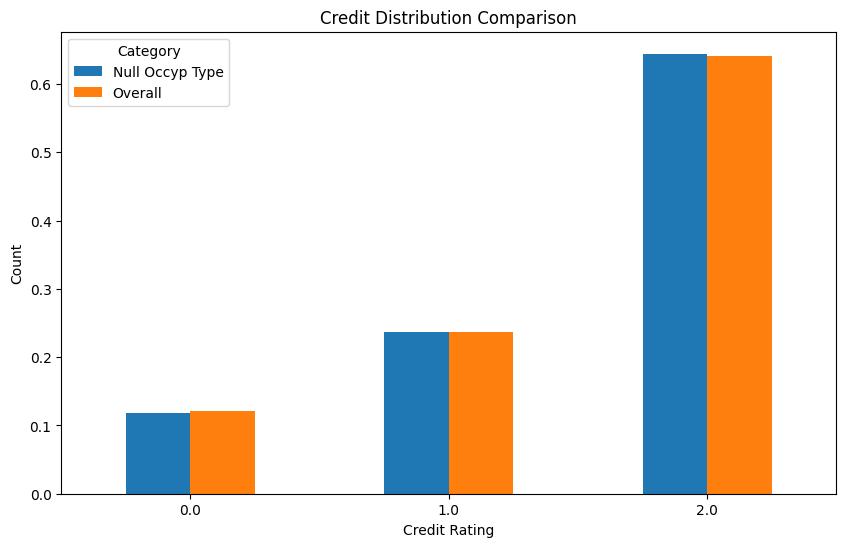

In [5]:
# Recalculating the value counts without normalization for better visualization
null_occyp_credit_counts = train[train['occyp_type'].isnull()]['credit'].value_counts(normalize=True)
overall_credit_counts = train['credit'].value_counts(normalize=True)

# Combining the data into a single DataFrame for easier plotting
combined_counts = pd.DataFrame({
    'Null Occyp Type': null_occyp_credit_counts,
    'Overall': overall_credit_counts
}).sort_index()

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
combined_counts.plot(kind='bar', ax=ax)

ax.set_title('Credit Distribution Comparison')
ax.set_xlabel('Credit Rating')
ax.set_ylabel('Count')
ax.legend(title='Category')
plt.xticks(rotation=0)

plt.show()

In [3]:
# # 1. 결측치 처리
train.fillna('NaN', inplace=True)
test.fillna('NaN', inplace=True)
# train.drop(columns = 'occyp_type', inplace=True)
# test.drop(columns = 'occyp_type', inplace=True)

In [4]:
# 2. 이상치 처리
# train['family_size'] > 7 인 데이터 제거
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

In [5]:
# 1. 의미없는 변수 제거
# 중복처리 못하는 index 대신 ID 만들기
# FLAG_MOBIL:모든 값이 1로 동일
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [6]:
# 2. DAYS_EMPLOYED : 양수인 데이터는 현재 무직자로 판단, 0 처리
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [7]:
# 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED : 음수값 -> 양수 변환
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [8]:
# 4. 파생변수

for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    # 고용되기 전까지의 기간을 알면, 해당 기간 동안의 생활 패턴이나 경제적 상태를 파악 가능
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED'] # 총 소득을 고용되기 전까지의 일수로 나눈 비율, 고용되기 전의 경제적 자립도나 소득 수준을 파악
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365 #  나이는 많은 모델에서 중요한 변수, 행동 패턴, 경제적 안정성, 건강 상태 등과 관련
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달), DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365 # 장기 근속자는 경제적 안정성이 높고, 대출 상환 능력이 좋음
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수) = 개인의 경제적 능력, 얼마나 효율적으로 경제 활동을 하는지
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']

    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = (
      df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +
      df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +
      df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +
      df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +
      df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +
      df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +
      df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +
      df['house_type'].astype(str)  + '_' + df['occyp_type'].astype(str)
    )
# category_income 소득 구간을 분류
def category_income(data: pd.DataFrame) -> pd.DataFrame:
    data["income_total"] = data["income_total"] / 10000  # 소득을 10,000으로 나누어 단위를 조정
    conditions = [
        (data["income_total"].le(18)),  # 소득이 18 이하인 경우
        (data["income_total"].gt(18) & data["income_total"].le(33)),  # 소득이 18 초과 33 이하인 경우
        (data["income_total"].gt(33) & data["income_total"].le(49)),  # 소득이 33 초과 49 이하인 경우
        (data["income_total"].gt(49) & data["income_total"].le(64)),  # 소득이 49 초과 64 이하인 경우
        (data["income_total"].gt(64) & data["income_total"].le(80)),  # 소득이 64 초과 80 이하인 경우
        (data["income_total"].gt(80) & data["income_total"].le(95)),  # 소득이 80 초과 95 이하인 경우
        (data["income_total"].gt(95) & data["income_total"].le(111)),  # 소득이 95 초과 111 이하인 경우
        (data["income_total"].gt(111) & data["income_total"].le(126)),  # 소득이 111 초과 126 이하인 경우
        (data["income_total"].gt(126) & data["income_total"].le(142)),  # 소득이 126 초과 142 이하인 경우
        (data["income_total"].gt(142)),  # 소득이 142 초과인 경우
    ]
    choices = [i for i in range(10)]  # 0부터 9까지의 숫자 리스트 생성

    data["income_total"] = np.select(conditions, choices)  # 조건에 따라 income_total 값을 선택
    return data

train = category_income(train)
test = category_income(test)

In [9]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,0,1,Commercial associate,Higher education,Married,Municipal apartment,13899,...,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,0,2,Working,Higher education,Married,House / apartment,19087,...,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,0,1,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,0,0,State servant,Higher education,Married,House / apartment,15037,...,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...


In [10]:
# 1. Numeric, Category 컬럼 분류
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit') # test와 맞춰서 credit 제거, 대신할 타겟 변수 있는지 확인
print("숫자형 특성 개수: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("범주형 특성 개수: ", len(categorical_feats))

숫자형 특성 개수:  21
범주형 특성 개수:  9


In [ ]:
# # 5. 파생변수와 다중공선을 보이는 컬럼 삭제
# # 두 개 이상의 설명 변수가 강한 상관관계를 가져, 변수 간의 독립성이 깨지는 문제
# cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
# train.drop(cols, axis=1, inplace=True)
# test.drop(cols, axis=1, inplace=True)

In [11]:
# 재확인
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit') # test와 맞춰서 credit 제거, 대신할 타겟 변수 있는지 확인
print("숫자형 특성 개수: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("범주형 특성 개수: ", len(categorical_feats))

숫자형 특성 개수:  21
범주형 특성 개수:  9


In [12]:
# 2. Log Scale (income_total)
# 값이 음수거나 0이 되는 것을 방지하기 위해 먼저 1을 더하고, 그런 다음에 로그 변환
# 데이터의 분포를 보다 정규 분포에 가깝게 만들어 주거나, 너무 큰 값의 영향을 줄여줌
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total']) # log1p(x) = log(1+x)

In [13]:
# 3. OrdinalEncoder
# 카테고리 변수는 ordinal_encoder 변환
# ID는 변환 후 정수 처리
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [14]:
# 5. StandardScale
# 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [15]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [16]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

In [ ]:
# !pip install imbalanced-learn

In [ ]:
# from imblearn.over_sampling import SMOTE

# skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
# folds = []
# for train_idx, valid_idx in skfold.split(X, y):
#     folds.append((train_idx, valid_idx))

# cat_pred = np.zeros((X.shape[0], n_class))
# cat_pred_test = np.zeros((X_test.shape[0], n_class))
# cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'ID']

# for fold in range(n_fold):
#     print(f'\n----------------- Fold {fold} -----------------\n')
#     train_idx, valid_idx = folds[fold]
#     X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

#     # 오버샘플링 적용
#     smote = SMOTE(random_state=seed)
#     X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#     train_data = Pool(data=X_train_res, label=y_train_res, cat_features=cat_cols)
#     valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

#     model_cat = CatBoostClassifier(iterations=n_est, random_seed=seed, task_type='GPU', use_best_model=True, early_stopping_rounds=100)
#     model_cat.fit(train_data, eval_set=valid_data, verbose=100)

#     cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
#     cat_pred_test += model_cat.predict_proba(X_test) / n_fold

#     print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

# print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

In [81]:
sub = pd.read_csv(path + 'sample_submission.csv')
sub.iloc[:, 1:] = cat_pred_test
# sub.iloc[:, 1:] = voting_pred_test
# sub.iloc[:, 1:] = stacking_pred_test
sub

,index,0,1,2
0,26457,0.091382,0.157763,0.750855
1,26458,0.179006,0.300513,0.520482
2,26459,0.068762,0.115084,0.816154
3,26460,0.085000,0.124014,0.790986
4,26461,0.110063,0.165011,0.724926
...,...,...,...,...
9995,36452,0.078828,0.138118,0.783054
9996,36453,0.212181,0.325583,0.462236
9997,36454,0.059561,0.098666,0.841773
9998,36455,0.141813,0.276110,0.582077


In [82]:
sub.to_csv('submission0618_kaggle_stacking.csv', index=False)

In [ ]:
# # from catboost import CatBoostClassifier, Pool
# # from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# # from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import VotingClassifier

# # 설정
# n_est = 2000
# seed = 42
# n_fold = 15
# n_class = 3

# target = 'credit'
# X = train.drop(target, axis=1)
# y = train[target]
# X_test = test

# skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
# folds = []
# for train_idx, valid_idx in skfold.split(X, y):
#     folds.append((train_idx, valid_idx))

# # Initialize predictions
# cat_pred = np.zeros((X.shape[0], n_class))
# # lgb_pred = np.zeros((X.shape[0], n_class))
# xgb_pred = np.zeros((X.shape[0], n_class))
# cat_pred_test = np.zeros((X_test.shape[0], n_class))
# # lgb_pred_test = np.zeros((X_test.shape[0], n_class))
# xgb_pred_test = np.zeros((X_test.shape[0], n_class))

# cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'ID']
# # cat_cols = ['gender',
# #             'car',
# #             'reality',
# #             'income_type',
# #             'edu_type',
# #             'family_type',
# #             'house_type',
# #             'ID']

# for fold in range(n_fold):
#     print(f'\n----------------- Fold {fold} -----------------\n')
#     train_idx, valid_idx = folds[fold]
#     X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

#     # CatBoost
#     train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
#     valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
#     model_cat = CatBoostClassifier(iterations=n_est, random_seed=seed, task_type='GPU', use_best_model=False, early_stopping_rounds=100)
#     model_cat.fit(train_data, eval_set=valid_data, verbose=100)
#     cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
#     cat_pred_test += model_cat.predict_proba(X_test) / n_fold

#     # # LightGBM
#     # model_lgb = LGBMClassifier(n_estimators=n_est, random_state=seed)
#     # model_lgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='logloss', verbose=100)
#     # lgb_pred[valid_idx] = model_lgb.predict_proba(X_valid)
#     # lgb_pred_test += model_lgb.predict_proba(X_test) / n_fold

#     # XGBoost
#     model_xgb = XGBClassifier(n_estimators=n_est, random_state=seed, use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
#     model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=100)
#     xgb_pred[valid_idx] = model_xgb.predict_proba(X_valid)
#     xgb_pred_test += model_xgb.predict_proba(X_test) / n_fold

#     print(f'CatBoost CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
#     # print(f'LightGBM CV Log Loss Score: {log_loss(y_valid, lgb_pred[valid_idx]):.6f}')
#     print(f'XGBoost CV Log Loss Score: {log_loss(y_valid, xgb_pred[valid_idx]):.6f}')

# # Combine predictions using average for voting
# # avg_pred = (cat_pred + lgb_pred + xgb_pred) / 3
# # avg_pred_test = (cat_pred_test + lgb_pred_test + xgb_pred_test) / 3
# avg_pred = (cat_pred + xgb_pred) / 2
# avg_pred_test = (cat_pred_test + xgb_pred_test) / 2

# print(f'\tCatBoost Log Loss: {log_loss(y, cat_pred):.6f}')
# # print(f'\tLightGBM Log Loss: {log_loss(y, lgb_pred):.6f}')
# print(f'\tXGBoost Log Loss: {log_loss(y, xgb_pred):.6f}')
# print(f'\tVoting Log Loss: {log_loss(y, avg_pred):.6f}')

# # Voting Classifier
# voting_clf = VotingClassifier(estimators=[
#     ('cat', model_cat),
#     # ('lgb', model_lgb),
#     ('xgb', model_xgb)],
#     voting='soft')

# voting_clf.fit(X, y)
# voting_pred_test = voting_clf.predict_proba(X_test)

# # Stacking
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# stacking_clf = StackingClassifier(estimators=[
#     ('cat', model_cat),
#     # ('lgb', model_lgb),
#     ('xgb', model_xgb)],
#     final_estimator=LogisticRegression(),
#     cv=skfold)

# stacking_clf.fit(X, y)
# stacking_pred_test = stacking_clf.predict_proba(X_test)

# print("Voting Classifier Predictions:\n", voting_pred_test)
# print("Stacking Classifier Predictions:\n", stacking_pred_test)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측값 생성
# cat_pred_final = model_cat.predict(X_test)
# xgb_pred_final = model_xgb.predict(X_test)
# voting_pred_final = voting_clf.predict(X_test)
# stacking_pred_final = stacking_clf.predict(X_test)

# 평가 보고서 생성 및 출력
print("CatBoost Classification Report:\n", classification_report(y_valid, cat_pred_test, target_names=['class_0', 'class_1', 'class_2']))
print("XGBoost Classification Report:\n", classification_report(y_valid, xgb_pred_test, target_names=['class_0', 'class_1', 'class_2']))
print("Voting Classifier Classification Report:\n", classification_report(y_valid, voting_pred_test, target_names=['class_0', 'class_1', 'class_2']))
print("Stacking Classifier Classification Report:\n", classification_report(y_valid,stacking_pred_test, target_names=['class_0', 'class_1', 'class_2']))

# 혼동 행렬(Confusion Matrix)
print(f'CatBoost Confusion Matrix:\n{confusion_matrix(y_valid, cat_pred_final)}')
print(f'XGBoost Confusion Matrix:\n{confusion_matrix(y_valid, xgb_pred_final)}')
print(f'Voting Classifier Confusion Matrix:\n{confusion_matrix(y_valid, voting_pred_final)}')
print(f'Stacking Classifier Confusion Matrix:\n{confusion_matrix(y_valid, stacking_pred_final)}')


In [ ]:
# import optuna
# from catboost import CatBoostClassifier, Pool
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss
# import numpy as np

# # 데이터 설정
# target = 'credit'
# X = train.drop(target, axis=1)
# y = train[target]
# X_test = test
# skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
# folds = []
# for train_idx, valid_idx in skfold.split(X, y):
#     folds.append((train_idx, valid_idx))

# cat_cols = ['gender',
#             'car',
#             'reality',
#             'income_type',
#             'edu_type',
#             'family_type',
#             'house_type',
#             'ID']

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'depth': trial.suggest_int('depth', 4, 12),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'border_count': trial.suggest_int('border_count', 32, 128),
#         'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
#         'eval_metric': 'MultiClass',
#         'early_stopping_rounds': 100,
#         'random_seed': seed,
#         'task_type': 'GPU',  # Enable GPU
#         'devices': '0'  # Specify GPU device
#     }

#     cat_pred = np.zeros((X.shape[0], n_class))

#     for fold in range(n_fold):
#         train_idx, valid_idx = folds[fold]
#         X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
#         train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
#         valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

#         model_cat = CatBoostClassifier(**params)
#         model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, verbose=0)

#         cat_pred[valid_idx] = model_cat.predict_proba(X_valid)

#     score = log_loss(y, cat_pred)
#     return score

# # Optuna 스터디 생성 및 최적화 (TPE Sampler 사용)
# sampler = optuna.samplers.TPESampler(seed=seed)  # TPE 샘플러 지정
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # 최적의 하이퍼파라미터 출력
# print("Best hyperparameters: ", study.best_params)

In [18]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier(
#       iterations=1419,           # 학습을 위한 트리의 수
#       learning_rate=0.024783034932626707,        # 학습률
#       depth=12,                   # 트리의 깊이
#       l2_leaf_reg=5.7517097990090145,             # L2 정규화 계수
#       border_count=115,           # 각 특성에 대해 고려할 구간의 수
      random_strength=1.908222017359766,         # 모델에 임의성을 추가하여 과적합을 줄이는 데 사용
      random_seed=seed,          # 랜덤 시드 설정
      early_stopping_rounds=100, # 조기 중단 기준
      eval_metric='MultiClass',  # 평가 지표 설정
      verbose=100,                # 학습 과정 출력 주기
      task_type='GPU'
  )
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True)

  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.145369
0:	learn: 1.0182071	test: 1.0170373	best: 1.0170373 (0)	total: 9.57ms	remaining: 9.57s
100:	learn: 0.7121850	test: 0.6893796	best: 0.6892659 (98)	total: 830ms	remaining: 7.39s
200:	learn: 0.6816874	test: 0.6843064	best: 0.6843064 (200)	total: 1.65s	remaining: 6.55s
300:	learn: 0.6517437	test: 0.6780254	best: 0.6779974 (299)	total: 2.46s	remaining: 5.72s
400:	learn: 0.6255637	test: 0.6786309	best: 0.6776036 (308)	total: 3.3s	remaining: 4.93s
bestTest = 0.6776035854
bestIteration = 308
Shrink model to first 309 iterations.
CV Log Loss Score: 0.677604

----------------- Fold 1 -----------------

Learning rate set to 0.145369
0:	learn: 1.0182448	test: 1.0179460	best: 1.0179460 (0)	total: 9.67ms	remaining: 9.66s
100:	learn: 0.7114358	test: 0.7121182	best: 0.7119738 (92)	total: 802ms	remaining: 7.13s
200:	learn: 0.6785083	test: 0.7077497	best: 0.7077497 (200)	total: 1.62s	remaining: 6.45s
300:	learn: 0.6512697	test: 0

In [21]:
from sklearn.metrics import classification_report
# Overall classification report
y_pred = np.argmax(cat_pred, axis=1)
print('Overall Classification Report:\n', classification_report(y, y_pred))

Overall Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.13      0.21      3222
         1.0       0.66      0.43      0.52      6267
         2.0       0.74      0.95      0.83     16962

    accuracy                           0.73     26451
   macro avg       0.68      0.50      0.52     26451
weighted avg       0.71      0.73      0.68     26451



In [71]:
# 데이터 증강
from imblearn.over_sampling import SMOTE
# Assuming X, y, X_test, n_fold, seed, and n_class are defined
# Apply SMOTE to the training data
smote = SMOTE(random_state=seed)
X_res, y_res = smote.fit_resample(X, y)

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X_res, y_res):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X_res.shape[0], n_class))  # Adjusted to X_res shape
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid = X_res.iloc[train_idx], X_res.iloc[valid_idx]
    y_train, y_valid = y_res[train_idx], y_res[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(
#         iterations=1419,
#         learning_rate=0.024783034932626707,
#         depth=12,
#         l2_leaf_reg=5.7517097990090145,
#         border_count=115,
#         random_strength=1.908222017359766,
        random_seed=seed,
        early_stopping_rounds=100,
        eval_metric='MultiClass',
        verbose=100,
        task_type='GPU'
    )
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    # Generate classification report for the current fold
    y_pred_fold = np.argmax(cat_pred[valid_idx], axis=1)
    print(f'Classification Report for Fold {fold}:\n', classification_report(y_valid, y_pred_fold))

# Overall Log Loss
print(f'\tLog Loss: {log_loss(y_res, cat_pred):.6f}')

# Matching the original y with cat_pred
y_pred_res = np.zeros((X.shape[0], n_class))
for i, index in enumerate(X.index):
    y_pred_res[i] = cat_pred[X_res.index == index].mean(axis=0)

# Overall classification report with original y
y_pred = np.argmax(y_pred_res, axis=1)
print('Overall Classification Report with Original y:\n', classification_report(y, y_pred))


----------------- Fold 0 -----------------

Learning rate set to 0.1553
0:	learn: 1.0466955	test: 1.0399257	best: 1.0399257 (0)	total: 10.8ms	remaining: 10.8s
100:	learn: 0.6374496	test: 0.6368029	best: 0.6368029 (100)	total: 810ms	remaining: 7.21s
200:	learn: 0.5944864	test: 0.6137334	best: 0.6137334 (200)	total: 1.64s	remaining: 6.53s
300:	learn: 0.5595059	test: 0.5981856	best: 0.5981204 (298)	total: 2.49s	remaining: 5.78s
400:	learn: 0.5324873	test: 0.5854272	best: 0.5854272 (400)	total: 3.3s	remaining: 4.93s
500:	learn: 0.5100272	test: 0.5767775	best: 0.5767114 (499)	total: 4.16s	remaining: 4.14s
600:	learn: 0.4896470	test: 0.5691641	best: 0.5691047 (599)	total: 4.98s	remaining: 3.31s
700:	learn: 0.4715283	test: 0.5626982	best: 0.5626982 (700)	total: 5.84s	remaining: 2.49s
800:	learn: 0.4544689	test: 0.5571403	best: 0.5571403 (800)	total: 6.66s	remaining: 1.66s
900:	learn: 0.4396965	test: 0.5519294	best: 0.5519044 (894)	total: 7.48s	remaining: 822ms
999:	learn: 0.4259632	test: 0.5

In [74]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

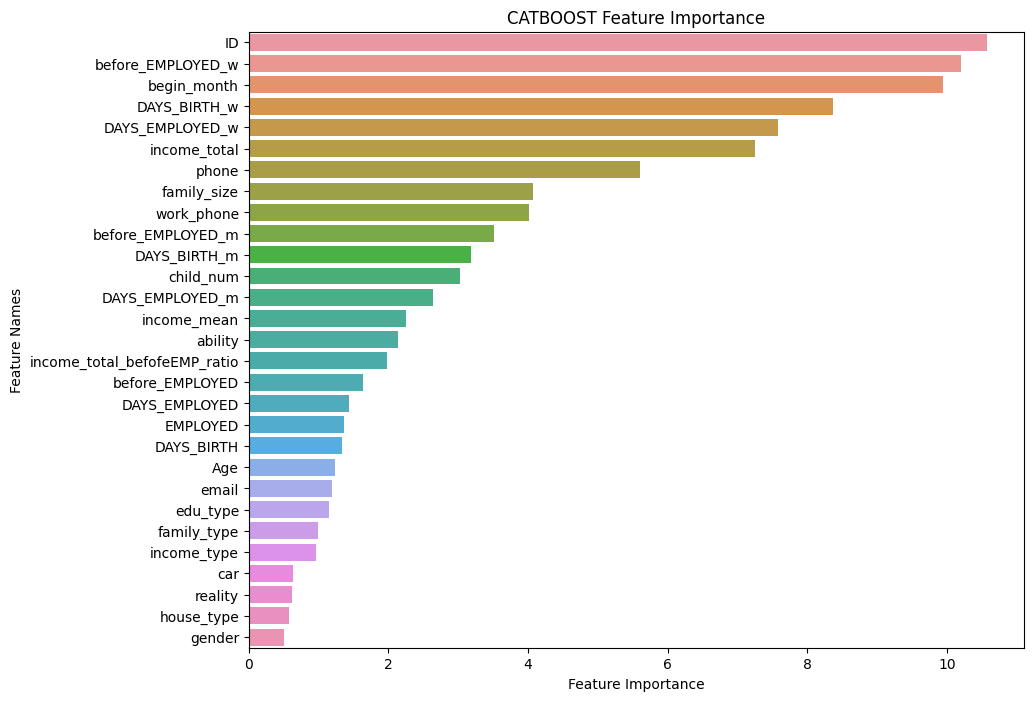

In [75]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
import numpy as np
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# 설정
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds = []
for train_idx, valid_idx in skfold.split(X, y):
    folds.append((train_idx, valid_idx))

# Initialize predictions
cat_pred = np.zeros((X.shape[0], n_class))
xgb_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
xgb_pred_test = np.zeros((X_test.shape[0], n_class))

cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'ID']

for fold in range(n_fold):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]

    # SMOTE 적용
    sm = SMOTE(random_state=seed)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # CatBoost
    train_data = Pool(data=X_train_res, label=y_train_res, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
    model_cat = CatBoostClassifier(iterations=n_est, random_seed=seed, task_type='GPU', use_best_model=False, early_stopping_rounds=100,
                                   class_weights=[1, 1, 2])  # class2 가중치 증가
    model_cat.fit(train_data, eval_set=valid_data, verbose=100)
    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold

    # XGBoost
    model_xgb = XGBClassifier(n_estimators=n_est, random_state=seed, use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist',
                              scale_pos_weight=2)  # class2 가중치 증가
    model_xgb.fit(X_train_res, y_train_res, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=100)
    xgb_pred[valid_idx] = model_xgb.predict_proba(X_valid)
    xgb_pred_test += model_xgb.predict_proba(X_test) / n_fold

    print(f'CatBoost CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    print(f'XGBoost CV Log Loss Score: {log_loss(y_valid, xgb_pred[valid_idx]):.6f}')

# Combine predictions using average for voting
avg_pred = (cat_pred + xgb_pred) / 2
avg_pred_test = (cat_pred_test + xgb_pred_test) / 2

print(f'\tCatBoost Log Loss: {log_loss(y, cat_pred):.6f}')
print(f'\tXGBoost Log Loss: {log_loss(y, xgb_pred):.6f}')
print(f'\tVoting Log Loss: {log_loss(y, avg_pred):.6f}')

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('cat', model_cat),
    ('xgb', model_xgb)],
    voting='soft')

voting_clf.fit(X, y)
voting_pred_test = voting_clf.predict_proba(X_test)

# Stacking
stacking_clf = StackingClassifier(estimators=[
    ('cat', model_cat),
    ('xgb', model_xgb)],
    final_estimator=LogisticRegression(),
    cv=skfold)

stacking_clf.fit(X, y)
stacking_pred_test = stacking_clf.predict_proba(X_test)

print("Voting Classifier Predictions:\n", voting_pred_test)
print("Stacking Classifier Predictions:\n", stacking_pred_test)

In [79]:
# Final classification reports
print("\nCatBoost Classification Report:")
print(classification_report(y, np.argmax(cat_pred, axis=1)))

print("\nXGBoost Classification Report:")
print(classification_report(y, np.argmax(xgb_pred, axis=1)))

print("\nVoting Classifier Classification Report:")
print(classification_report(y, np.argmax(avg_pred, axis=1)))

print("\nStacking Classifier Classification Report:")
print(classification_report(y, stacking_clf.predict(X)))


CatBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.29      0.37      3222
         1.0       0.72      0.35      0.47      6267
         2.0       0.73      0.94      0.82     16962

    accuracy                           0.72     26451
   macro avg       0.66      0.52      0.56     26451
weighted avg       0.71      0.72      0.68     26451


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.29      0.37      3222
         1.0       0.65      0.45      0.53      6267
         2.0       0.75      0.90      0.82     16962

    accuracy                           0.72     26451
   macro avg       0.63      0.55      0.57     26451
weighted avg       0.70      0.72      0.70     26451


Voting Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.28      0.37      3222
         1.0       0.7

In [80]:
print("Voting Classifier Predictions:\n", voting_pred_test)
print("Stacking Classifier Predictions:\n", stacking_pred_test)

Voting Classifier Predictions:
 [[0.03177279 0.08027913 0.8879481 ]
 [0.19324586 0.27640595 0.53034819]
 [0.01531033 0.03691583 0.94777381]
 ...
 [0.01197168 0.02329266 0.96473565]
 [0.18989292 0.31017454 0.49993254]
 [0.01251214 0.08694025 0.90054763]]
Stacking Classifier Predictions:
 [[0.09138157 0.15776327 0.75085516]
 [0.17900571 0.30051254 0.52048175]
 [0.06876168 0.11508393 0.8161544 ]
 ...
 [0.05956143 0.09866568 0.84177288]
 [0.14181305 0.27611033 0.58207662]
 [0.08061877 0.15760193 0.76177929]]


In [83]:
print(f'\tCatBoost Log Loss: {log_loss(y, cat_pred):.6f}')
print(f'\tXGBoost Log Loss: {log_loss(y, xgb_pred):.6f}')
print(f'\tVoting Log Loss: {log_loss(y, avg_pred):.6f}')

	CatBoost Log Loss: 0.758836
	XGBoost Log Loss: 0.728880
	Voting Log Loss: 0.714484


In [84]:
sub = pd.read_csv(path + 'sample_submission.csv')
# sub.iloc[:, 1:] = cat_pred_test
# sub.iloc[:, 1:] = voting_pred_test
sub.iloc[:, 1:] = stacking_pred_test
sub

,index,0,1,2
0,26457,0.091382,0.157763,0.750855
1,26458,0.179006,0.300513,0.520482
2,26459,0.068762,0.115084,0.816154
3,26460,0.085000,0.124014,0.790986
4,26461,0.110063,0.165011,0.724926
...,...,...,...,...
9995,36452,0.078828,0.138118,0.783054
9996,36453,0.212181,0.325583,0.462236
9997,36454,0.059561,0.098666,0.841773
9998,36455,0.141813,0.276110,0.582077
